# Bayesian inference analysis

This notebook uses our own attempt at bayesian inference to determine whether the devices are shopper. 

## Theory

Bayes' theory gives the probability of an event A occuring given that event B has occured:

$$p(A|B) = \frac{p(A)p(B|A)}{p(B)},$$

where p(A) is known as the the posterior, p(A|B) the prior, and $\frac{p(B|A)}{p(B)}$ the quotient.

We can use this equation to determine the probability of the device (mac address) being a shopper:

$$p(\text{shopper}| f(d)) = \frac{p(\text{shopper})p(f(d)|\text{shopper})}{p(\text{shopper})p(f(d)|\text{shopper}) + p(\text{not shopper})p(f(d)|\text{not shopper})},$$

where d is a particular device and f is a probability density function describing a feature of the devices.

For each device, various features can be extracted from their signals. The signals contain the location and time. With this information, features such as the average velocity, accelation, turning angle of the device can be calculated. Each features can be plotted for all the devices to understand the overall distribution. These distribution can then be turned into probability density functions $f(d)$ which are used for the Bayesian inference.

The prior is our initial guess which will be updated by the quotient to give the posterior probability. For example, the prior can be set so that the probability that the device is a shopper is also 50%, therefore, the probability it is not a shopper is 50%. Different priors can be tested to determine how much this affects the final posterior.

The probability $p(f(d)|\text{shopper})$ can be calculated from probability density function generated by each feature using only devices that are shoppers. Unfortunately, we do not know which devices are shoppers and, therefore, cannot get the exact distribution.

A distribution can be approximated by looking for devices who are definitely not shoppers. In our case, these devices would have appeared between the hours of 3:00am to 5:00am and, therefore, can't be shoppers because the mall was not open. By using this for the probability density function of "not shoppers", we can use all the other signals to find a probability density function for "shoppers". Using distributions for all the features, the posterior for each device can be calculated.

Sequential Bayes can be implemented. By passing the posterior from the previous feature to the prior when evaluating the next feature, the sequence leads to an overall posterior for a device given a list of features. Therefore, each device will have a probability of it being a shopper at the end of the sequence.

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils

In [4]:
from msci.cleaning import bayesian_inference

## Import data

In [5]:
mac_address_df = utils.import_mac_addresses()

In [6]:
print('{} mac addresses with {} features'.format(mac_address_df.shape[0], mac_address_df.shape[1]))

154152 mac addresses with 18 features


In [7]:
signal_df = utils.import_signals()

## Investigation

### Is out of hours

The number of devices that were found between the hours of 3:00am to 5:00am are shown below. The devices which emit fewer than 10 signals have been removed because they might be devices with mac address randomisation (this is explained in another notebook).

In [8]:
mac_address_df[mac_address_df.frequency > 10].is_out_of_hours.value_counts()

0    22642
1      695
Name: is_out_of_hours, dtype: int64

There are fewer devices found within these hours (695). This is expected because there are no shoppers which are the main source of devices.

Devices outside of hours will definitely not be shoppers because the shops are closed. Therefore, the distributions of the characteristics (features) of the devices outside of hours will help classifiy all the devices with similar features to also be stationary device.

### Example: length of stay

The length of stay is the best example of polarisation between the shoppers and non-shoppers. 

A kde is used to plot both the shoppers and non-shoppers probability density functions. A kde (kernal density estimation) is a non-parametric way to estimate the probability density function of a random variable. It's a data smoothing problem where inferences about the population are made, based on a finite data sample.

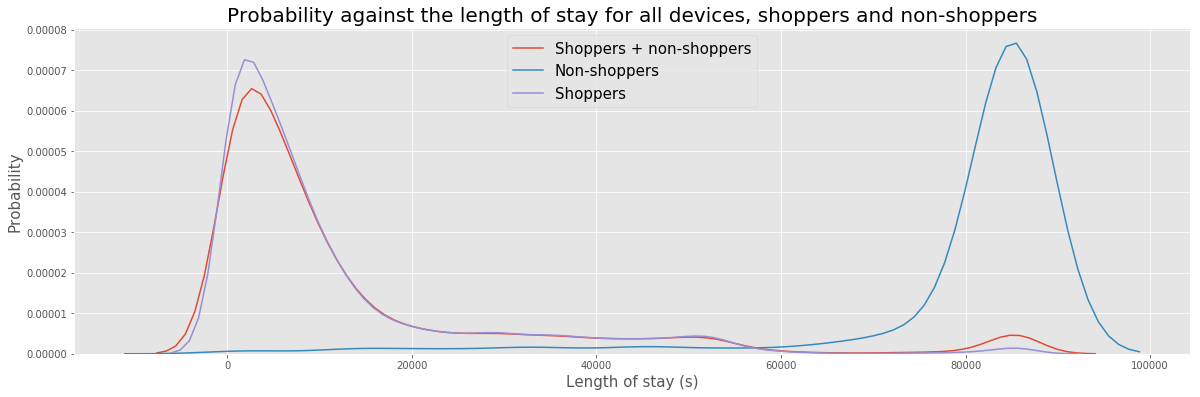

In [82]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

length_of_stay_df = mac_address_df[mac_address_df.frequency > 10].length_of_stay
length_of_stay_df = length_of_stay_df.rename('Shoppers + non-shoppers')
length_of_stay_not_shopper_df = mac_address_df[(mac_address_df.frequency > 10) & (mac_address_df.is_out_of_hours==1)].length_of_stay
length_of_stay_not_shopper_df = length_of_stay_not_shopper_df.rename("Non-shoppers")
length_of_stay_shopper_df = mac_address_df[(mac_address_df.frequency > 10) & (mac_address_df.is_out_of_hours==0)].length_of_stay
length_of_stay_shopper_df = length_of_stay_shopper_df.rename("Shoppers")

sns.kdeplot(data=length_of_stay_df, ax=ax1)
sns.kdeplot(data=length_of_stay_not_shopper_df, ax=ax1)
sns.kdeplot(data=length_of_stay_shopper_df, ax=ax1)

ax1.set_title('Probability against the length of stay for all devices, shoppers and non-shoppers', fontsize=20)
ax1.set_ylabel('Probability', fontsize=15)
ax1.set_xlabel('Length of stay (s)', fontsize=15);
ax1.legend(fontsize=15);

Three distributions are shown above. The red line shows the length of stay of all the devices; there is a peak around 5000 seconds (~ 1 1/2 hours) which seems about right for the average time a person spends in the shopping mall. Furthermore, there is a smaller peak around 85000 (~23 hours) which are probabably stationary devices. By creating kde for non-shoppers (purple) and shoppers (blue), we can clearly see that there are two very distinct distribution centered around the two bumps.

The limitation of the kde is that it can approximate distribution wrongly. This can be seen by fitting the distribution with a gaussian shape that can have a negative length of stay; this does not make sense. The kde is the best fitting method to estimate probability density functions so they are still used even though they are not perfect.

Bayesian inference will find a probability for a device being a shoppers and a non-shopper given the two distributions above and the device's length of stay. For example, there is a device which has a high length of stay (~80000) will have a much higher probability of being a non-shopper than a shopper. 

In [10]:
random_device = mac_address_df[mac_address_df.frequency > 10].loc[0]
print('Length of stay of random device: {}'.format(random_device.length_of_stay))

Length of stay of random device: 86335


In [11]:
length_of_stay_shopper_kde = stats.kde.gaussian_kde(length_of_stay_shopper_df.tolist())
length_of_stay_not_shopper_kde = stats.kde.gaussian_kde(length_of_stay_not_shopper_df.tolist())

print(
    'The kde evaluates to {:.2g} for the shopper & {:.2g} for the non-shopper'.format(
        length_of_stay_shopper_kde(random_device.length_of_stay)[0], 
        length_of_stay_not_shopper_kde(random_device.length_of_stay)[0]
    )
)

The kde evaluates to 1.3e-06 for the shopper & 7.4e-05 for the non-shopper


Evaluating Bayes' theorem mentioned above:

In [12]:
p_shopper, p_non_shopper = 0.5, 0.5
p_length_of_stay_given_shopper = length_of_stay_shopper_kde(random_device.length_of_stay)[0]
p_length_of_stay_given_non_shopper = length_of_stay_not_shopper_kde(random_device.length_of_stay)[0]

p_shopper_given_length_of_stay = \
                            (p_shopper * p_length_of_stay_given_shopper) / \
    (p_shopper * p_length_of_stay_given_shopper + p_non_shopper * p_length_of_stay_given_non_shopper)
    
p_non_shopper_given_length_of_stay = \
                            (p_non_shopper * p_length_of_stay_given_non_shopper) / \
    (p_shopper * p_length_of_stay_given_shopper + p_non_shopper * p_length_of_stay_given_non_shopper)
    
print(
    'The probability is {:.2g} of being a shopper & {:.2g} of being a non-shopper'.format(
        p_shopper_given_length_of_stay, 
        p_non_shopper_given_length_of_stay
    )
)

The probability is 0.017 of being a shopper & 0.98 of being a non-shopper


Even after adjusting the priors, the posterior does not vastly change. The new probability can be used as the prior for the next feature and, thus, the process is sequential. An overall posterior is calculated at the end.

### Features

The all the features which are used are:

In [87]:
bayesian_inference.FEATURE_LIST = [
    'frequency',
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'av_turning_angle_velocity',
    'av_path_length',
    'av_straightness'
]

bayesian_inference.FEATURE_LIST

['frequency',
 'length_of_stay',
 'radius_of_gyration',
 'count_density_variance',
 'av_speed',
 'av_turning_angle',
 'av_turning_angle_velocity',
 'av_path_length',
 'av_straightness']

Currently, no feature selection has been done but an investigation to make sure all the features are independent needs to be performed.

### Sequential Bayes

The devices are first cleaned, removing any that have less than 10 signals or that have null values in their features.

In [88]:
mac_address_clean_df = mac_address_df[mac_address_df.frequency > 10]
mac_address_clean_df = mac_address_clean_df[mac_address_clean_df.notnull()]

In [89]:
%%time

mac_address_probabilities = bayesian_inference.sequential(
    prior=p_non_shopper, 
    feature_df=mac_address_clean_df, 
    feature_list=bayesian_inference.FEATURE_LIST
)

frequency
length_of_stay
radius_of_gyration
count_density_variance
av_speed
av_turning_angle
av_turning_angle_velocity
av_path_length
av_straightness
Wall time: 1min 20s


### Analysis

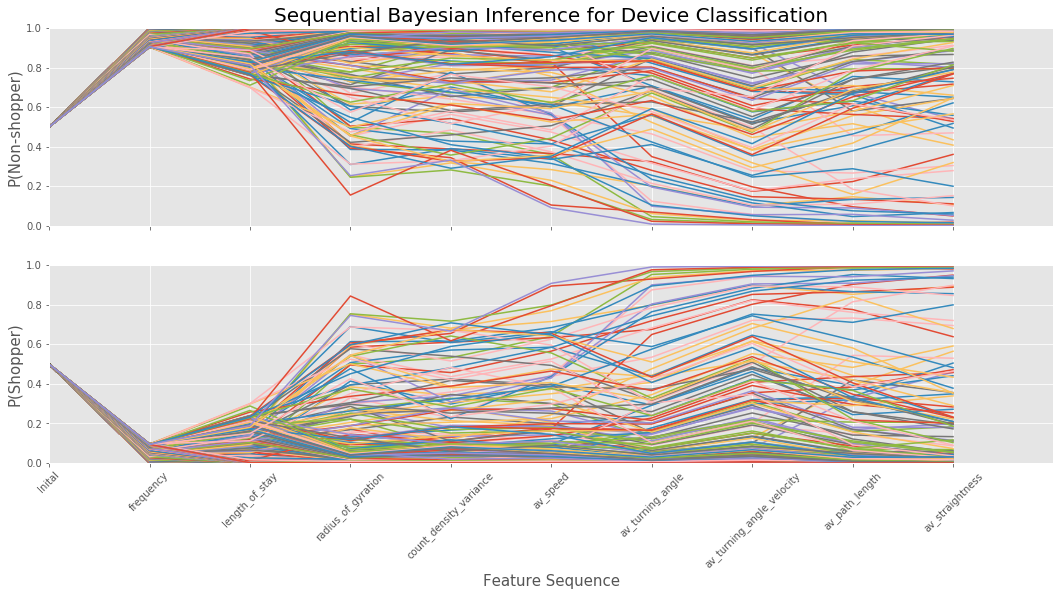

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))

feature_list = ['Inital'] + bayesian_inference.FEATURE_LIST
non_shopper = [i[0] for i in mac_address_probabilities]
shopper = [i[1] for i in mac_address_probabilities]

for mac in range(500):
    y = [i[mac] for i in non_shopper]
    axes[0].plot(range(len(feature_list)), y)
    
for mac in range(500):
    y = [i[mac] for i in shopper]
    axes[1].plot(range(len(feature_list)), y)

axes[0].set_title('Sequential Bayesian Inference for Device Classification', fontsize=20)
axes[0].set_ylabel('P(Non-shopper)', fontsize=15)
axes[0].set_ylim((0, 1))
axes[0].set_xlim((0, len(feature_list)))
axes[0].set_xticks(range(len(feature_list)))
axes[0].set_xticklabels([])

axes[1].set_xlabel('Feature Sequence', fontsize=15)
axes[1].set_ylabel('P(Shopper)', fontsize=15)
axes[1].set_xlim((0, len(feature_list)))
axes[1].set_ylim((0, 1))

plt.xticks(range(len(feature_list)), feature_list, rotation='45');

This shows the updating of the probabilities of each device as it gets classified with each feature. The final posteriors have found probabilities of each device being a shopper or a non-shopper. 

The graph shows that the sequential process changes the probabilities gradually without changing rapidly. This provides evidence that none of the features dominate the process.

In [117]:
confidence_level = 0.05

def find_label(x):
    if x > (1-confidence_level):
        return 1
    elif x < confidence_level:
        return 0
    else:
        return 0.5

mac_address_clean_df['shopper_probability'] = mac_address_probabilities[-1][1]
mac_address_clean_df['shopper_label'] = mac_address_clean_df['shopper_probability'].apply(find_label)

In [118]:
mac_address_clean_df.shopper_label.value_counts()

1.0    20412
0.5     1802
0.0     1123
Name: shopper_label, dtype: int64

More signals have been classified as shoppers than stations which is expected. A confidence level of 0.05 has been set which means that the probability of the device being a shopper given the features is over 95% certain.

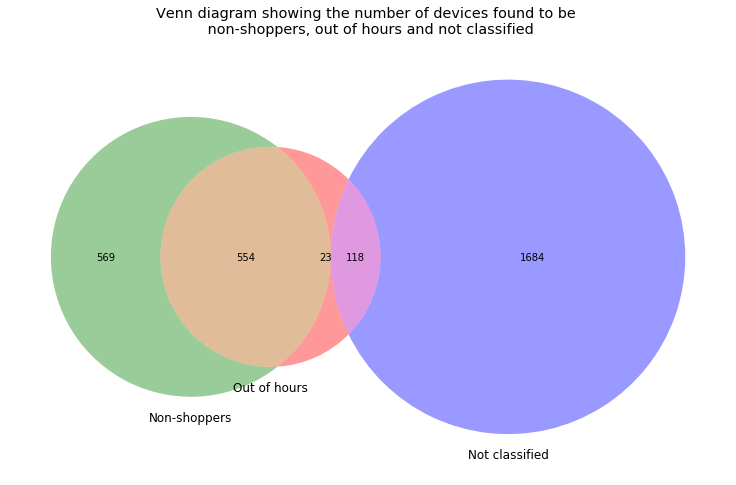

In [137]:
from matplotlib_venn import venn3

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))

set1s = set(mac_address_clean_df[mac_address_clean_df.is_out_of_hours == 1].index.tolist())
set2s = set(mac_address_clean_df[mac_address_clean_df.shopper_label == 0].index.tolist())
set3s = set(mac_address_clean_df[(mac_address_clean_df.shopper_label == 0.5)].index.tolist())


venn3(
    [set1s, set2s, set3s], 
    ('Out of hours', 'Non-shoppers', 'Not classified'), 
    ax=ax1
)

ax1.set_title('Venn diagram showing the number of devices found to be \n non-shoppers, out of hours and not classified');

The non-shoppers with high confidence (0.05) have a number of devices that are `out of hours`. The 141 devices which are `out of hours` but are considered shoppers could have been removed due to them being mall workers who work in the early hours. This gives the appearence that they are shoppers. Further test will be performed to see if this theory is correct. 

The majority (118 out of 141) of these devices, that are considered shoppers but are `out of hours`, have not been classified. This means that there is not a high probability that they are shoppers either.